# Step 1: data preprocess
1. Normalization
2. Feature selection
3. Noise reduction (Gaussian filter)

## 1 Import library

In [1]:
import pandas as pd
import numpy as np
import os
import time
import csv
import math
import matplotlib.pyplot as plt
from sklearn import preprocessing
from scipy.ndimage.filters import gaussian_filter1d

## 2 Load data

### 2.1 Set constants

In [2]:
file_path = '../data/0_raw_data/'
file_no = '1'
train_file = file_path+'train_FD00'+file_no+'.txt'
test_file = file_path+'test_FD00'+file_no+'.txt'
test_rul_file = file_path+'RUL_FD00'+file_no+'.txt'
n_ftrs = 26
op_col_name = [ 'setting1', 'setting2', 'setting3']
ftr_col_name = [ 's1', 's2', 's3','s4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
             's15', 's16', 's17', 's18', 's19', 's20', 's21']
col_name = ['id', 'cycle'] + op_col_name+ ftr_col_name
n_op = 1

### 2.2 Read data

In [3]:
# read training data - It is the aircraft engine run-to-failure data.
raw_train_df = pd.read_csv(train_file,names = col_name, header=None,delim_whitespace=True,index_col=0)
raw_test_df = pd.read_csv(test_file,names = col_name, header=None,delim_whitespace=True,index_col=0)
raw_rul_df = pd.read_csv(test_rul_file, names=['RUL'],header=None,delim_whitespace=True)

In [4]:
train_df = raw_train_df
test_df = raw_test_df
rul_df = raw_rul_df

In [5]:
n_train_units = len(train_df.groupby('id').size())
n_test_units = len(test_df.groupby('id').size())
n_test_units

100

## 3 Preprocess

### 3.1 Normalization

In [6]:
scaler = preprocessing.StandardScaler()
train_df[ftr_col_name] = pd.DataFrame(scaler.fit_transform(train_df[ftr_col_name]), 
                                                        columns=ftr_col_name, 
                                                        index=train_df.index)

In [7]:
test_df[ftr_col_name] = pd.DataFrame(scaler.transform(test_df[ftr_col_name]), 
                                                        columns=ftr_col_name, 
                                                        index=test_df.index)

### 3.2 Calculate RUL

In [8]:
train_df['RUL'] = ''
for i in range(n_train_units):
    train_df.loc[i + 1,'RUL'] = train_df.loc[i + 1,'cycle'].max() - train_df.loc[i + 1,'cycle']

In [9]:
test_df['RUL'] = ''
for i in range(n_test_units):
    test_df.loc[i + 1,'RUL'] =  - test_df.loc[i + 1,'cycle'] + (test_df.loc[i + 1,'cycle'].max() + rul_df.loc[i,'RUL'])

### 3.3 Piecewise RUL

### 3.4 Drop rebundant features

In [10]:
#rebundant_ftr_name = ['s1','s5','s6','s10','s16','s17','s18','s19','setting1','setting2','setting3']
rebundant_ftr_name = ['s1','s5','s6', 's8', 's9','s10', 's13', 's14','s16','s17','s18','s19', 's20', 's21','setting1','setting2','setting3']

In [11]:
#train_df =train_df.loc[:,selected_ftr_name]
train_df.drop(rebundant_ftr_name, axis=1, inplace=True)
#train_df.head()

In [12]:
test_df.drop(rebundant_ftr_name, axis=1, inplace=True)

In [13]:
selected_ftr_name = train_df.columns.difference(['id','cycle','RUL'])
selected_ftr_name

Index(['s11', 's12', 's15', 's2', 's3', 's4', 's7'], dtype='object')

## 4 Noise reduction

### 4.1 Gaussian filter

In [14]:
def smoothGaussian(data,ftr_col_name,sigma):
    for unit_no in data.index.unique():
        for col in ftr_col_name:
            data.loc[unit_no, col] = gaussian_filter1d(data.loc[unit_no,col], sigma)
    return data

In [15]:
gauss_sigma = 3
train_df = smoothGaussian(train_df, selected_ftr_name,gauss_sigma)

In [16]:
test_df = smoothGaussian(test_df, selected_ftr_name,gauss_sigma)

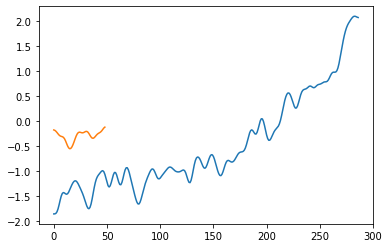

In [17]:
unit_no = 2
plt.plot(range(len(train_df.loc[unit_no])),train_df.loc[unit_no,'s2'])
plt.plot(range(len(test_df.loc[unit_no])),test_df.loc[unit_no,'s4'])
plt.show()

## 5 Save processed data

In [18]:
processed_data_file = '../data/1_processed_data'
if os.path.exists(processed_data_file)==False:
    os.makedirs(processed_data_file)

In [21]:
train_df.to_csv(processed_data_file+'/train_data_FD00'+file_no+'.csv',index=True,header=True)

In [22]:
test_df.to_csv(processed_data_file+'/test_data_FD00'+file_no+'.csv',index=True,header=True)